# Standard scattering tests

In this notebook we demonstrate how the function `standard_scattering` from the `qedtool` package can be used. We compare our computation with standard analytical expressions from the literature, thereby "testing" the function and identifying the magnitude of the associated numerical errors. For this purpose we choose to compute a commonly encountered quantity in tree-level quantum electrodynamics (QED), namely the (fermion) spin and (photon) polarisation-averaged squared magnitudes of the Feynman amplitudes associated with a scattering process. We define this quantity as

$$\smash{\partial_\Pi\mathcal{P} = \frac{1}{4}\sum_{\alpha,\bar{\alpha}}|\mathcal{M}_{\alpha \rightarrow \bar{\alpha}}|^2},$$

where $\mathcal{M}_{\alpha \rightarrow \bar{\alpha}}$ is the Feynman amplitude for a $2$-to-$2$ particle scattering in QED taking two particles in the $\alpha$ helicity-polarisation combination to $\bar{\alpha}$. Here $\alpha, \bar{\alpha} \in \{\mathrm{L}, \mathrm{R}\}^{\otimes 2}$, where $L$ labels a fermion's left-handed helicity eigenvalue or a photon's left-handed circular polarisation eigenvalue. $R$ labels right-handedness in a similar way. The quantity $\smash{\partial_\Pi\mathcal{P}}$ is given by the differential probability (`'dp'`) output of `standard_scattering` in the case of a maximally-mixed incoming (pre-scattering) state $\rho = \sum_{i=1}^4 w_i|\psi_i\rangle\langle\psi_i|$. Here

$$|\psi_1\rangle = |p_+,\mathrm{L};p_-,\mathrm{L}\rangle\,, \qquad\quad |\psi_2\rangle = |p_+,\mathrm{L};p_-,\mathrm{R}\rangle\,, \qquad\quad |\psi_3\rangle = |p_+,\mathrm{R};p_-,\mathrm{L}\rangle\,, \qquad\quad |\psi_4\rangle = |p_+,\mathrm{R};p_-,\mathrm{R}\rangle\,,$$

and $w_i = \frac14$ for all $i$. Here $p_\pm$ are the four-momenta of the two incoming particles, where we take $p_+ = (\varepsilon_\mathbf{p}, |\mathbf{p}|\hat{\mathbf{z}})$ as the four-momentum of the incoming electron as all considered processes involve at least one electron. The $6$ considered processes are:
- Compton scattering 
- Bhabha scattering 
- Møller scattering
- Electron-positron annihilation (to two photons)
- Electron-muon scattering
- Electron-positron to muon-antimuon (pair annihilation and creation)

For each process, $\smash{\partial_\Pi\mathcal{P}}$ is computed numerically over a range of avlues of $p$ (centre-of-mass momentum magnitude of scattering particles) and $\theta$ (polar scattering angle), while the azimuthal scattering angle is kept at $\phi = 0$.

First, we import `numpy` and `qedtool` for all computations and all packages required for plotting our results.

In [1]:
# Import qedtool and numpy:
import qedtool as qtl
import numpy as np

# Import packages for plotting:
import matplotlib.pyplot as plt
import matplotlib as mpl
import cmasher as cmr
from matplotlib.colors import LogNorm

# Enable LaTeX and set a font:
plt.rc('text', usetex=True)
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rcParams.update({'font.size': 11, 'text.latex.preamble': r'\usepackage{amsfonts}'})
plt.rcParams['font.family'] = 'Bitstream Charter'

We define all constants that will be used in the followning computation.

In [2]:
# Define required constants:
me = qtl.constant("electron mass")
mmu = qtl.constant("muon mass")
e = qtl.constant("elementary charge")

Next, we define a function `M_av_array_theo` that plots an array of $\smash{\partial_\Pi\mathcal{P}}$ based on an analytical expression from the literature, provided by the function `M_av_elem_theo`, which will be defined for each of the six scattering processes. This function is defined here in order to simplify the form of all `M_av_elem_theo` defined in the rest of the notebook.

In [3]:
def M_av_array_theo(M_av_elem_theo, p_array, theta_array):

    '''
    Calcualtes an array of average squared magnitudes of the Feynman amplitudes 
    for a given tree-level QED scattering process. The output array runs over  
    all input p and theta values.

    Parameters
    -------
    M_av_elem_theo :
        Function which calculates the average squared magnitude of Feynman 
        amplitudes for given p and theta values, based on an expression from
        the literature.
    p_array : array_like 
        Values of the incoming particles' three-momentum magnitude (in the 
        centre-of-mass frame) over which all output quantities are calculated.
    theta_array : array_like 
        Values of the polar angle (angle between the outgoing and incoming 
        electron three-momenta) over which all output quantities are 
        calculated.
        
    Returns
    -------
    M_array : array_like
        Array of average squared magnitudes of the Feynman amplitudes for a 
        given process, for all input p and theta values.
    '''
    # Initialise an array of zeros:
    M_array = np.array([[0. for _ in theta_array] for _ in p_array])
    
    # Loop over all p and theta values:
    for p in range(len(p_array)):
        for theta in range(len(theta_array)):

            # Compute the average squared magnitude of Feynman amplitudes for 
            # given p and theta:
            M_array[p,theta] = M_av_elem_theo(p_array[p],theta_array[theta])
            
    return M_array

Here we define the `plot_M_av` function, whcih plots the $p$-$\theta$ distributions of 
- $\smash{\partial_\Pi\mathcal{P}}$ values computed by `qedtool`, entitled $\smash{\partial_\Pi\mathcal{P}}$  (QEDTool)
- $\smash{\partial_\Pi\mathcal{P}}$ values based on an analytical expression from the literature, entitled $\smash{\partial_\Pi\mathcal{P}}$  (Theoretical)
- The difference of the QEDTool and Theoretical results, entitled Difference.

In [4]:
def plot_M_av(theta, p, M_av_qed, M_av_theo, M_av_diff, scattering_title, 
              p_vals, p_labels, theta_vals, theta_labels, log_norm=False):
    
    '''
    Creates three plots of the average squared magnitude of the Feynman 
    amplitudes for a given tree-level QED scattering process. The first plot 
    gives the distribution computed by the `qedtool` package, the second one 
    gives a theoretical prediction taken from the literature, and the third plot 
    gives the difference between the first two. Results are plotted with 
    respect to p (the centre-of-mass three-momentum magnitude of the two 
    scattering particles) amd theta (the polar scattering angle, taken to be 
    between the incoming and outgoing electrons for each of the 6 standard 
    processes).

    Parameters
    -------
    theta : array_like 
        Values of the polar angle (angle between the outgoing and incoming 
        electron three-momenta) over which all output quantities are 
        calculated.
    p : array_like 
        Values of the incoming particles' three-momentum magnitude (in the 
        centre-of-mass frame) over which all output quantities are calculated.
    M_av_qed : array_like
        Array of average squared magnitude of Feynman amplitudes computed by 
        the `qedtool` function `standard_scattering`.
    M_av_theo : array_like
        Array of average squared magnitude of Feynman amplitudes computed based 
        on an analytical expression from the literature.
    M_av_diff : array_like
        Array of values giving the difference between M_av_qed and M_av_theo.
        calculated.
    scattering_title : 
        Suptitle of the three subplots.
    p_vals : array_like
        p values for which labels are put on the y axis of the plots.
    p_labels : array_like
        List of strings giving p-value labels of the y axis of the plots.
    theta_vals : array_like
        Theta values for which labels are put on the x axis of the plots.
    theta_labels : array_like
        List of strings giving theta-value labels of the x axis of the plots.
    log_norm : bool
        Boolean setting all plots to have a logarithmic scale.
    '''
    
    # Create a plot of 3 subplots with required size:
    cm = 1 / 2.54
    fig, ax = plt.subplots(1, 3, figsize=(0.9*15*cm, 5*cm), \
                           constrained_layout=True)
    
    # Set ipnut suptitle:
    plt.suptitle(scattering_title)
    
    if log_norm == False:
        
        # Create first (qedtool) subplot:
        im0 = ax[0].matshow(M_av_qed, 
                            cmap = cmr.get_sub_cmap('turbo', 0, 1), 
                            origin='lower', 
                            extent=[theta[0], theta[-1], p[0], p[-1]], 
                            aspect=(theta[-1]-theta[0])/(p[-1]-p[0])
                            )
        
        # Create second (theoretical) subplot:
        im1 = ax[1].matshow(M_av_theo, 
                            cmap = cmr.get_sub_cmap('turbo', 0, 1), 
                            origin='lower', 
                            extent=[theta[0], theta[-1], p[0], p[-1]], 
                            aspect=(theta[-1]-theta[0])/(p[-1]-p[0])
                            )
        
        # Create third (difference) subplot:
        im2 = ax[2].matshow(M_av_diff, 
                            cmap = cmr.get_sub_cmap('YlGnBu_r', 0, 1), 
                            origin='lower', 
                            extent=[theta[0], theta[-1], p[0], p[-1]], 
                            aspect=(theta[-1]-theta[0])/(p[-1]-p[0])
                            )
    
    if log_norm == True:
        
        # Create first (qedtool) subplot:
        im0 = ax[0].matshow(M_av_qed, 
                            cmap = cmr.get_sub_cmap('turbo', 0, 1), 
                            origin='lower', 
                            extent=[theta[0], theta[-1], p[0], p[-1]], 
                            aspect=(theta[-1]-theta[0])/(p[-1]-p[0]),
                            norm=LogNorm(vmin=M_av_qed.min(), vmax=M_av_qed.max())
                            )
        
        # Create second (theoretical) subplot:
        im1 = ax[1].matshow(M_av_theo, 
                            cmap = cmr.get_sub_cmap('turbo', 0, 1), 
                            origin='lower', 
                            extent=[theta[0], theta[-1], p[0], p[-1]], 
                            aspect=(theta[-1]-theta[0])/(p[-1]-p[0]),
                            norm=LogNorm(vmin=M_av_theo.min(), vmax=M_av_theo.max())
                            )
        
        # Create third (difference) subplot:
        im2 = ax[2].matshow(M_av_diff, 
                            cmap = cmr.get_sub_cmap('YlGnBu_r', 0, 1), 
                            origin='lower', 
                            extent=[theta[0], theta[-1], p[0], p[-1]], 
                            aspect=(theta[-1]-theta[0])/(p[-1]-p[0]))
    
    # Set subplot title:
    ax[0].set_title('$\partial_\Pi \mathcal{P}$ (QEDTool)', fontsize=11) 

    # Set y-axis label, ticks, and tick labels:
    ax[0].set_ylabel('$|\mathbf{p}|$~(MeV)', labelpad=5)
    ax[0].yaxis.set_ticks(p_vals)
    ax[0].set_yticklabels(p_labels)

    # Set subplot title with no y-axis labels:
    ax[1].set_title('$\partial_\Pi \mathcal{P}$ (Theoretical)', fontsize=11)
    ax[1].set_yticklabels([])
    
    # Set subplot title with no y-axis labels:
    ax[2].set_title('Difference', fontsize=11)
    ax[2].set_yticklabels([])
    
    # Loop over all subplots:
    for j in range(3):
        ax[j].xaxis.set_ticks_position('bottom')                        # x-axis tick positions
        ax[j].set_xlim(theta[0], theta[-1])                             # x-axis range
        ax[j].set_ylim(p[0], p[-1])                                     # y-axis range
        ax[j].xaxis.set_ticks(theta_vals)                               # x-axis tick values
        ax[j].set_xticklabels(theta_labels)                             # x-axis tick labels
        ax[j].yaxis.set_ticks(p_vals)                                   # y-axis tick values
        ax[j].xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))   # x-axis minor tick
        ax[j].yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))   # y-axis minor tick
        ax[j].tick_params(axis='both', which='both', direction='in',   
                          right=True, top=True, color='white')          # tick parameters
        ax[j].set_xlabel('$\\theta$', labelpad=5)                       # x-axis label
        
        # Set a white edge for all plots:
        for spine in ax[j].spines.values():
            spine.set_edgecolor('white')                            

    # Set colorbar parameters for all plots:    
    fig.colorbar(im0, ax=ax[0], aspect=12.25, fraction=0.083, pad=0.05)
    fig.colorbar(im1, ax=ax[1], aspect=12.25, fraction=0.083, pad=0.05)
    fig.colorbar(im2, ax=ax[2], aspect=12.25, fraction=0.083, pad=0.05)
    
    # Add a letter title to all plots:
    ax[0].annotate('(a)', (0.07, 0.81), xycoords='axes fraction', color='white')
    ax[1].annotate('(b)', (0.07, 0.81), xycoords='axes fraction', color='white')
    ax[2].annotate('(c)', (0.07, 0.81), xycoords='axes fraction', color='white')

# Compton scattering

First define the funciton that computes the average of the squared magnitudes of the Feynman amplitudes for tree-level Compton scattering, based on an analytical calculation.

In [5]:
def M_av_compton_theo(p, theta):

    '''
    Calcualtes an array of average squared magnitudes of the Feynman amplitudes 
    for tree-level Compton scattering. The output is computed for the input p 
    and theta values.

    Parameters
    -------
    p : float 
        Value of the incoming particles' three-momentum magnitude (in the 
        centre-of-mass frame)..
    theta_array : float 
        Value of the polar angle (angle between the outgoing and incoming 
        electron three-momenta).
        
    Returns
    -------
    M_array : float
        Value of average squared magnitudes of the Feynman amplitudes for a 
        given process, for all input p and theta values.
    '''
    
    # Set aziumthal angle to zero:
    phi=0

    # Electron centre-of-mass energy:
    E = np.sqrt(p**2 + me**2)
    
    # Incoming electron and photon four-momenta:
    p1 = qtl.FourVector(E, p, 0, 0)
    p2 = qtl.FourVector(p, p, np.pi, 0)
                
    # Outgoing photon four-momentum:
    q2 = qtl.FourVector(p, p, np.pi - theta, np.pi + phi)
    
    # Average squared magnitudes of the Feynman amplitudes:
    M_compton_av_theo_val = 2*e**4 * ( qtl.lorentzian_product(p1,q2) / \
        qtl.lorentzian_product(p1,p2) + qtl.lorentzian_product(p1,p2) / \
        qtl.lorentzian_product(p1,q2) + 2*me**2 * ( \
        1/qtl.lorentzian_product(p1,p2) - 1/qtl.lorentzian_product(p1,q2)) + \
        me**4 * (1/qtl.lorentzian_product(p1,p2) - \
                 1/qtl.lorentzian_product(p1,q2))**2)

    return M_compton_av_theo_val

To use `standard_scattering` first we define an array of incoming states.

In [6]:
# Define p, theta, and electron energy arrays:
p = np.linspace(0.1, 1, 60)
theta = np.linspace(0, np.pi, 60)
energy_e = np.sqrt(p**2 + me**2)

# Define list of classical probabilities:
w = [1/4, 1/4, 1/4, 1/4]

pmu_1 = []
pmu_2 = []

# Create lists of incoming particle four-momenta for all p:
for p_index in range(len(p)):
    pmu_1.append(qtl.FourVector(energy_e[p_index], p[p_index], 0, 0))
    pmu_2.append(-qtl.FourVector(p[p_index], p[p_index], 0, 0))

state_in_array = []

# Create list of incoming two-particle states for all p:
for p_index in range(len(p)):
    plus_l = qtl.QuantumState.single(pmu_1[p_index], "L")
    plus_r = qtl.QuantumState.single(pmu_1[p_index], "R")
    minus_l = qtl.QuantumState.single(pmu_2[p_index], "L")
    minus_r = qtl.QuantumState.single(pmu_2[p_index], "R")
    
    in_states = [plus_l*minus_l, plus_l*minus_r, plus_r*minus_l, plus_r*minus_r]
    state_in_array.append(qtl.QuantumState.mixed(in_states, w))

Now input all quantities into `standard_scattering`.

In [7]:
# Compute differential probability `dp`:
compton_output = qtl.standard_scattering(state_in_array, 'compton', pmu_1, pmu_2, p, 
            theta, phi=None, dp=True)

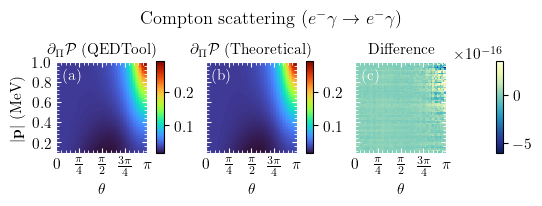

In [8]:
# Create variable of real `dp` output to remove 0 imaginary component:
M_av_qed = np.real(compton_output['dp'])

# Compute reference result:
M_av_theo = M_av_array_theo(M_av_compton_theo, p, theta)

# Calculate the difference in the two quantities:
M_av_diff = M_av_theo - M_av_qed

# Plot the results, setting a atitle and x-axis ticks:
plot_M_av(theta, p, M_av_qed, M_av_theo, M_av_diff, r'Compton scattering $(e^{-}\gamma\rightarrow e^{-}\gamma)$', 
            p_vals = [.2, .4, .6, .8, 1.],
            p_labels = [r'$0.2$', r'$0.4$', r'$0.6$', r'$0.8$', r'$1.0$'],
            theta_vals = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi], 
            theta_labels = [r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$'],
            log_norm=False)

# Bhabha scattering

Define the funciton that computes the average of the squared magnitudes of the Feynman amplitudes for tree-level Bhabha scattering, based on an analytical calculation.

In [9]:
def M_bhabha_av_theo(p, theta):

    '''
    Calcualtes an array of average squared magnitudes of the Feynman amplitudes 
    for tree-level Bhabha scattering. The output is computed for the input p 
    and theta values.

    Parameters
    -------
    p : float 
        Value of the incoming particles' three-momentum magnitude (in the 
        centre-of-mass frame)..
    theta_array : float 
        Value of the polar angle (angle between the outgoing and incoming 
        electron three-momenta).
        
    Returns
    -------
    M_array : float
        Value of average squared magnitudes of the Feynman amplitudes for 
        Bhabha scattering, for all input p and theta values.
    '''
    
    # Set aziumthal angle to zero:
    phi=0

    # Electron centre-of-mass energy:
    E = np.sqrt(p**2 + me**2)
    
    # Incoming electron and positron four-momenta:
    p1 = qtl.FourVector(E, p, 0, 0)
    #p2 = qtl.FourVector(E, p, np.pi, 0)
    p2 = -qtl.FourVector(E, p, 0, 0)

    # Outgoing electron and positron four-momentum:
    q1 = qtl.FourVector(E, p, theta, phi)
    q2 = qtl.FourVector(E, p, np.pi - theta, np.pi + phi)

    # s and t Mandelstam variables for scattering process:
    s_mand = qtl.lorentzian_product(p1 + p2, p1 + p2)
    t_mand = qtl.lorentzian_product(p1 - q1, p1 - q1)
    
    # Average squared magnitudes of the Feynman amplitudes:
    A = (8 * e**4)/(s_mand**2) * (qtl.lorentzian_product(p1,q1) * qtl.lorentzian_product(p2,q2) + qtl.lorentzian_product(p2,q1) * qtl.lorentzian_product(p1,q2) + me**2 * qtl.lorentzian_product(q1,q2) + me**2 * qtl.lorentzian_product(p1,p2) + 2*me**4)
    B = - (8 * e**4)/(s_mand*t_mand) * (qtl.lorentzian_product(p1,q1) * qtl.lorentzian_product(p2,q1) - qtl.lorentzian_product(p2,q1) * qtl.lorentzian_product(p1,p2))
    C = - (8 * e**4)/(s_mand*t_mand) * (qtl.lorentzian_product(p2,q2) * qtl.lorentzian_product(p1,q2) - qtl.lorentzian_product(p1,q2) * qtl.lorentzian_product(p1,p2))
    D = (8 * e**4)/(t_mand**2) * (qtl.lorentzian_product(p1,q2) * qtl.lorentzian_product(p2,q1) + qtl.lorentzian_product(p2,p1) * qtl.lorentzian_product(q1,q2) - me**2 * qtl.lorentzian_product(q1,p1) - me**2 * qtl.lorentzian_product(p2,q2) + 2*me**4)

    M_av_mag_squared = (A + B + C + D)

    return M_av_mag_squared

Define an array of incoming states.

In [10]:
# Define p, theta, and electron energy arrays:
p = np.linspace(1, 5, 60)
theta = np.linspace(np.pi/2, np.pi, 60)
energy_e = np.sqrt(p**2 + me**2)

# Define list of classical probabilities:
w = [1/4, 1/4, 1/4, 1/4]

pmu_1 = []
pmu_2 = []

# Create lists of incoming particle four-momenta for all p:
for p_index in range(len(p)):
    pmu_1.append(qtl.FourVector(energy_e[p_index], p[p_index], 0, 0))
    pmu_2.append(-qtl.FourVector(energy_e[p_index], p[p_index], 0, 0))

state_in_array = []

# Create list of incoming two-particle states for all p:
for p_index in range(len(p)):
    plus_l = qtl.QuantumState.single(pmu_1[p_index], "L")
    plus_r = qtl.QuantumState.single(pmu_1[p_index], "R")
    minus_l = qtl.QuantumState.single(pmu_2[p_index], "L")
    minus_r = qtl.QuantumState.single(pmu_2[p_index], "R")
    
    in_states = [plus_l*minus_l, plus_l*minus_r, plus_r*minus_l, plus_r*minus_r]
    state_in_array.append(qtl.QuantumState.mixed(in_states, w))

Now input all quantities into `standard_scattering`.

In [11]:
# Compute differential probability `dp`:
bhabha_output = qtl.standard_scattering(state_in_array, 'bhabha', pmu_1, pmu_2, p, 
            theta, phi=None, dp=True)

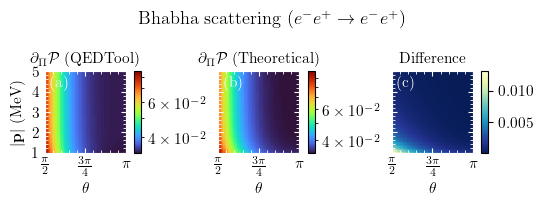

In [12]:
# Create variable of real `dp` output to remove 0 imaginary component:
M_av_qed = np.real(bhabha_output['dp'])

# Compute reference result:
M_av_theo = M_av_array_theo(M_bhabha_av_theo, p, theta)

# Calculate the difference in the two quantities:
M_av_diff = M_av_theo - M_av_qed

plot_M_av(theta, p, M_av_qed, M_av_theo, M_av_diff, r'Bhabha scattering $(e^{-} e^{+} \rightarrow e^{-} e^{+})$', 
            p_vals = [1, 2, 3, 4, 5],
            p_labels = [r'$1$', r'$2$', r'$3$', r'$4$', r'$5$'],
            theta_vals = [np.pi/2, 3*np.pi/4, np.pi], 
            theta_labels = [r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$'],
            log_norm=True)

# Møller scattering

Define the funciton that computes the average of the squared magnitudes of the Feynman amplitudes for tree-level Møller scattering, based on an analytical calculation.

In [13]:
def M_moller_av_theo(p, theta):

    '''
    Calcualtes an array of average squared magnitudes of the Feynman amplitudes 
    for tree-level Moller scattering. The output is computed for the input p 
    and theta values.

    Parameters
    -------
    p : float 
        Value of the incoming particles' three-momentum magnitude (in the 
        centre-of-mass frame)..
    theta_array : float 
        Value of the polar angle (angle between the outgoing and incoming 
        electron three-momenta).
        
    Returns
    -------
    M_array : float
        Value of average squared magnitudes of the Feynman amplitudes for 
        Moller scattering, for all input p and theta values.
    '''
    
    # Set aziumthal angle to zero:
    phi=0

    # Electron centre-of-mass energy:
    E = np.sqrt(p**2 + me**2)
    
    # s, t, and u-Mandelstam variables:
    t = 2 * p**2 * (np.cos(theta) - 1)
    u = - 2 * p**2 * (np.cos(theta) + 1)
    s = 4 * E**2
                
    # Outgoing photon four-momentum:
    q2 = qtl.FourVector(p, p, np.pi - theta, np.pi + phi)
    
    # Average squared magnitudes of the Feynman amplitudes:
    M_moller_av_theo_val = 2 * e**4 * ((s**2 + u**2 - 8 * me**2 * (s + u) + 24 * me**4) / t**2 \
                     + (s**2 + t**2 - 8 * me**2 * (s + t) + 24 * me**4) / u**2 \
                     + 2 * (s**2 - 8 * me**2 * s + 12 * me**4) / (t * u))

    return M_moller_av_theo_val

Define an array of incoming states.

In [14]:
# Define p, theta, and electron energy arrays:
p = np.linspace(1, 2, 60)
theta = np.linspace(1, 2, 60)
energy_e = np.sqrt(p**2 + me**2)

# Define list of classical probabilities:
w = [1/4, 1/4, 1/4, 1/4]

pmu_1 = []
pmu_2 = []

# Create lists of incoming particle four-momenta for all p:
for p_index in range(len(p)):
    pmu_1.append(qtl.FourVector(energy_e[p_index], p[p_index], 0, 0))
    pmu_2.append(-qtl.FourVector(energy_e[p_index], p[p_index], 0, 0))

state_in_array = []

# Create list of incoming two-particle states for all p:
for p_index in range(len(p)):
    plus_l = qtl.QuantumState.single(pmu_1[p_index], "L")
    plus_r = qtl.QuantumState.single(pmu_1[p_index], "R")
    minus_l = qtl.QuantumState.single(pmu_2[p_index], "L")
    minus_r = qtl.QuantumState.single(pmu_2[p_index], "R")
    
    in_states = [plus_l*minus_l, plus_l*minus_r, plus_r*minus_l, plus_r*minus_r]
    state_in_array.append(qtl.QuantumState.mixed(in_states, w))

Now input all quantities into `standard_scattering`.

In [15]:
# Compute differential probability `dp`:
moller_output = qtl.standard_scattering(state_in_array, 'moller', pmu_1, pmu_2, p, 
            theta, phi=None, dp=True)

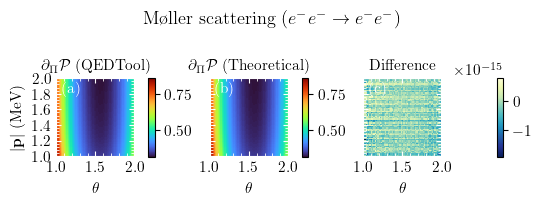

In [16]:
# Create variable of real `dp` output to remove 0 imaginary component:
M_av_qed = np.real(moller_output['dp'])

# Compute reference result:
M_av_theo = M_av_array_theo(M_moller_av_theo, p, theta)

# Calculate the difference in the two quantities:
M_av_diff = M_av_theo - M_av_qed

plot_M_av(theta, p, M_av_qed, M_av_theo, M_av_diff, r'Møller scattering $(e^{-} e^{-} \rightarrow e^{-} e^{-})$', 
            p_vals = [1, 1.2, 1.4, 1.6, 1.8, 2],
            p_labels = [r'$1.0$', r'$1.2$', r'$1.4$', r'$1.6$', r'$1.8$', r'2.0'],
            theta_vals = [1, 1.5, 2.0],
            theta_labels = [r'$1.0$', r'$1.5$', r'$2.0$'],
            log_norm=False)

# Electron-positron annihilation

Define the funciton that computes the average of the squared magnitudes of the Feynman amplitudes for tree-level electron-positron annihilation, based on an analytical calculation.

In [17]:
def M_ep_av_theo(p, theta):

    '''
    Calcualtes an array of average squared magnitudes of the Feynman amplitudes 
    for tree-level electron-positron annihilation. The output is computed for 
    the input p and theta values.

    Parameters
    -------
    p : float 
        Value of the incoming particles' three-momentum magnitude (in the 
        centre-of-mass frame)..
    theta_array : float 
        Value of the polar angle (angle between the outgoing and incoming 
        electron three-momenta).
        
    Returns
    -------
    M_array : float
        Value of average squared magnitudes of the Feynman amplitudes for 
        electron-positron annihilation, for all input p and theta values.
    '''
    
    # Set aziumthal angle to zero:
    phi=0

    # Electron centre-of-mass energy:
    E = np.sqrt(p**2 + me**2)
    
    # Incoming electron and positron four-momenta:
    p1 = qtl.FourVector(E, p, 0, 0)
    p2 = qtl.FourVector(E, p, np.pi, 0)
                
    # Outgoing electron and positron four-momentum:
    q1 = qtl.FourVector(E, E, theta, phi)
    q2 = qtl.FourVector(E, E, np.pi - theta, np.pi + phi)

    # Average squared magnitudes of the Feynman amplitudes:
    M_av_mag_squared = 2*e**4 * ((qtl.lorentzian_product(p1,q2))/(qtl.lorentzian_product(p1,q1))+((qtl.lorentzian_product(p1,q1))/(qtl.lorentzian_product(p1,q2))+2*me**2 * (1/(qtl.lorentzian_product(p1,q1)) + 1/(qtl.lorentzian_product(p1,q2))) - me**4 * (1/(qtl.lorentzian_product(p1,q1)) + 1/(qtl.lorentzian_product(p1,q2)))**2))

    return M_av_mag_squared

Define an array of incoming states.

In [18]:
# Define p, theta, and electron energy arrays:
p = np.linspace(0,1,60)
theta = np.linspace(0,np.pi,60)
energy_e = np.sqrt(p**2 + me**2)

# Define list of classical probabilities:
w = [1/4, 1/4, 1/4, 1/4]

pmu_1 = []
pmu_2 = []

# Create lists of incoming particle four-momenta for all p:
for p_index in range(len(p)):
    pmu_1.append(qtl.FourVector(energy_e[p_index], p[p_index], 0, 0))
    pmu_2.append(-qtl.FourVector(energy_e[p_index], p[p_index], 0, 0))

state_in_array = []

# Create list of incoming two-particle states for all p:
for p_index in range(len(p)):
    plus_l = qtl.QuantumState.single(pmu_1[p_index], "L")
    plus_r = qtl.QuantumState.single(pmu_1[p_index], "R")
    minus_l = qtl.QuantumState.single(pmu_2[p_index], "L")
    minus_r = qtl.QuantumState.single(pmu_2[p_index], "R")
    
    in_states = [plus_l*minus_l, plus_l*minus_r, plus_r*minus_l, plus_r*minus_r]
    state_in_array.append(qtl.QuantumState.mixed(in_states, w))

Now input all quantities into `standard_scattering`.

In [19]:
# Compute differential probability `dp`:
ep_output = qtl.standard_scattering(state_in_array, 'electron_positron_annihilation', pmu_1, pmu_2, p,
            theta, phi=None, dp=True)

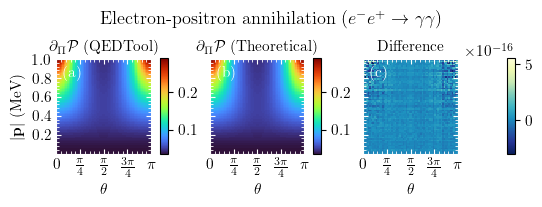

In [20]:
# Create variable of real `dp` output to remove 0 imaginary component:
M_av_qed = np.real(ep_output['dp'])

# Compute reference result:
M_av_theo = M_av_array_theo(M_ep_av_theo, p, theta)

# Calculate the difference in the two quantities:
M_av_diff = M_av_theo - M_av_qed

# Plot the results, setting a atitle and x-axis ticks:
plot_M_av(theta, p, M_av_qed, M_av_theo, M_av_diff, r'Electron-positron annihilation $(e^{-} e^{+} \rightarrow \gamma \gamma)$', 
            p_vals = [.2, .4, .6, .8, 1.],
            p_labels = [r'$0.2$', r'$0.4$', r'$0.6$', r'$0.8$', r'$1.0$'],
            theta_vals = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi], 
            theta_labels = [r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$'],
            log_norm=False)

# Electron-muon scattering

Define the funciton that computes the average of the squared magnitudes of the Feynman amplitudes for tree-level electron-muon scattering, based on an analytical calculation.

In [21]:
def M_elem_e_mu_av_theo(p, theta):

    '''
    Calcualtes an array of average squared magnitudes of the Feynman amplitudes 
    for tree-level electron-muon scattering. The output is computed for 
    the input p and theta values.

    Parameters
    -------
    p : float 
        Value of the incoming particles' three-momentum magnitude (in the 
        centre-of-mass frame)..
    theta_array : float 
        Value of the polar angle (angle between the outgoing and incoming 
        electron three-momenta).
        
    Returns
    -------
    M_array : float
        Value of average squared magnitudes of the Feynman amplitudes for 
        electron-muon scattering, for all input p and theta values.
    '''
    
    # Set aziumthal angle to zero:
    phi = 0

    # Electron and muon centre-of-mass energy:
    E_e = np.sqrt(p**2 + me**2)
    E_mu = np.sqrt(p**2 + mmu**2)
    
    # # Incoming electron and positron four-momenta:
    p1 = qtl.FourVector(E_e, p, 0, 0)
    p2 = qtl.FourVector(E_mu, p, np.pi, 0)
                
    # Outgoing electron and positron four-momentum:
    q1 = qtl.FourVector(E_e, p, theta, phi)
    q2 = qtl.FourVector(E_mu, p, np.pi - theta, np.pi + phi)

    # s, t, and u Mandelstam variables for scattering process:
    s_mand = qtl.lorentzian_product(p1 + p2, p1 + p2)
    t_mand = qtl.lorentzian_product(p1 - q1, p1 - q1)
    u_mand = qtl.lorentzian_product(p1 - q2, p1 - q2)

    # Average squared magnitudes of the Feynman amplitudes:
    M_av_mag_squared = ( 2*e**4 / t_mand**2 ) * ( s_mand**2 + u_mand**2 - 4 * (me**2 + mmu**2) * (s_mand + u_mand) + 6 * (me**2 + mmu**2)**2)

    return M_av_mag_squared

Define an array of incoming states.

In [22]:
# Define p, theta, and electron energy arrays:
p = np.linspace(1, 2, 60)
theta = np.linspace(np.pi/4, np.pi, 60)
energy_e = np.sqrt(p**2 + me**2)
energy_mu = np.sqrt(p**2 + mmu**2)

# Define list of classical probabilities:
w = [1/4, 1/4, 1/4, 1/4]

pmu_1 = []
pmu_2 = []

# Create lists of incoming particle four-momenta for all p:
for p_index in range(len(p)):
    pmu_1.append(qtl.FourVector(energy_e[p_index], p[p_index], 0, 0))
    pmu_2.append(-qtl.FourVector(energy_mu[p_index], p[p_index], 0, 0))

state_in_array = []

# Create list of incoming two-particle states for all p:
for p_index in range(len(p)):
    plus_l = qtl.QuantumState.single(pmu_1[p_index], "L")
    plus_r = qtl.QuantumState.single(pmu_1[p_index], "R")
    minus_l = qtl.QuantumState.single(pmu_2[p_index], "L")
    minus_r = qtl.QuantumState.single(pmu_2[p_index], "R")
    
    in_states = [plus_l*minus_l, plus_l*minus_r, plus_r*minus_l, plus_r*minus_r]
    state_in_array.append(qtl.QuantumState.mixed(in_states, w))

Now input all quantities into `standard_scattering`.

In [23]:
# Compute differential probability `dp`:
electron_muon_output = qtl.standard_scattering(state_in_array, 'electron_muon', pmu_1, pmu_2, p, 
            theta, phi=None, dp=True)

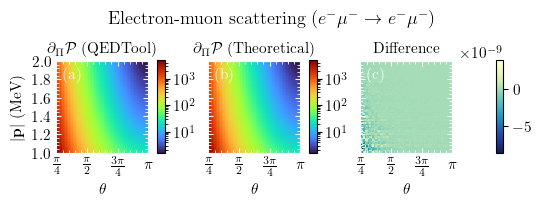

In [24]:
# Create variable of real `dp` output to remove 0 imaginary component:
M_av_qed = np.real(electron_muon_output['dp'])

# Compute reference result:
M_av_theo = M_av_array_theo(M_elem_e_mu_av_theo, p, theta)

# Calculate the difference in the two quantities:
M_av_diff = M_av_theo - M_av_qed

# Plot the results, setting a atitle and x-axis ticks:
plot_M_av(theta, p, M_av_qed, M_av_theo, M_av_diff, r'Electron-muon scattering $(e^{-} \mu^{-} \rightarrow e^{-} \mu^{-})$', 
            p_vals = [1, 1.2, 1.4, 1.6, 1.8, 2],
            p_labels = [r'$1.0$', r'$1.2$', r'$1.4$', r'$1.6$', r'$1.8$', r'$2.0$'],
            theta_vals = [np.pi/4, np.pi/2, 3*np.pi/4, np.pi], 
            theta_labels = [r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$'],
            log_norm=True)

# Electron-positron to muon-antimuon

Define the funciton that computes the average of the squared magnitudes of the Feynman amplitudes for tree-level electron-positron to muon-antimuon pair annihilation and creation, based on an analytical calculation.

In [25]:
def M_elem_e_mu_av_theo(p, theta):

    '''
    Calcualtes an array of average squared magnitudes of the Feynman amplitudes 
    for tree-level electron-positron to muon-antimuon scattering. The output is 
    computed for the input p and theta values.

    Parameters
    -------
    p : float 
        Value of the incoming particles' three-momentum magnitude (in the 
        centre-of-mass frame)..
    theta_array : float 
        Value of the polar angle (angle between the outgoing and incoming 
        electron three-momenta).
        
    Returns
    -------
    M_array : float
        Value of average squared magnitudes of the Feynman amplitudes for 
        electron-positron to muon-antimuon scattering, for all input p and 
        theta values.
    '''
    
    # Set aziumthal angle to zero:
    phi = 0

    # Electron and muon centre-of-mass energy:
    E_e = np.sqrt(p**2 + me**2)
    
    # Incoming electron and positron four-momenta:
    p1 = qtl.FourVector(E_e, p, 0, 0)
    p2 = qtl.FourVector(E_e, p, np.pi, 0)
                
    # Outgoing electron and positron four-momentum:
    q1 = qtl.FourVector(E_e, p, theta, phi)
    q2 = qtl.FourVector(E_e, p, np.pi - theta, np.pi + phi)

    # s, t, and u Mandelstam variables for scattering process:
    s_mand = qtl.lorentzian_product(p1 + p2, p1 + p2)
    t_mand = qtl.lorentzian_product(p1 - q1, p1 - q1)
    u_mand = qtl.lorentzian_product(p1 - q2, p1 - q2)
    
    # Average squared magnitudes of the Feynman amplitudes:
    M_av_mag_squared = e**4 * ((1 - 4 * mmu**2 / s_mand) * (1 - 4 * me**2 / s_mand) * np.cos(theta)**2 + 1 + (4/s_mand)*(me**2 + mmu**2))

    return M_av_mag_squared

Define an array of incoming states.

In [26]:
# Define p, theta, and electron energy arrays:
p = np.linspace(110, 160, 60)
theta = np.linspace(0, np.pi, 60)
energy_e = np.sqrt(p**2 + me**2)

# Define list of classical probabilities:
w = [1/4, 1/4, 1/4, 1/4]

pmu_1 = []
pmu_2 = []

# Create lists of incoming particle four-momenta for all p:
for p_index in range(len(p)):
    pmu_1.append(qtl.FourVector(energy_e[p_index], p[p_index], 0, 0))
    pmu_2.append(-qtl.FourVector(energy_e[p_index], p[p_index], 0, 0))

state_in_array = []

# Create list of incoming two-particle states for all p:
for p_index in range(len(p)):
    plus_l = qtl.QuantumState.single(pmu_1[p_index], "L")
    plus_r = qtl.QuantumState.single(pmu_1[p_index], "R")
    minus_l = qtl.QuantumState.single(pmu_2[p_index], "L")
    minus_r = qtl.QuantumState.single(pmu_2[p_index], "R")
    
    in_states = [plus_l*minus_l, plus_l*minus_r, plus_r*minus_l, plus_r*minus_r]
    state_in_array.append(qtl.QuantumState.mixed(in_states, w))

Now input all quantities into `standard_scattering`.

In [27]:
# Compute differential probability `dp`:
electron_positron_to_muon_antimuon_output = qtl.standard_scattering(state_in_array, 'electron_positron_to_muon_antimuon', pmu_1, pmu_2, p, 
            theta, phi=None, dp=True)

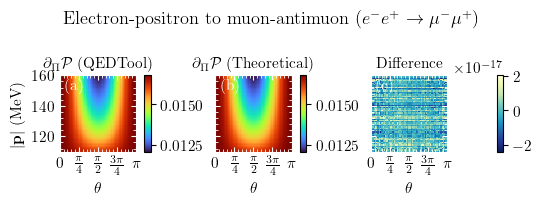

In [28]:
# Create variable of real `dp` output to remove 0 imaginary component:
M_av_qed = np.real(electron_positron_to_muon_antimuon_output['dp'])

# Compute reference result:
M_av_theo = M_av_array_theo(M_elem_e_mu_av_theo, p, theta)

# Calculate the difference in the two quantities:
M_av_diff = M_av_theo - M_av_qed

# Plot the results, setting a atitle and x-axis ticks:
plot_M_av(theta, p, M_av_qed, M_av_theo, M_av_diff, r'Electron-positron to muon-antimuon $(e^{-}e^{+}\rightarrow \mu^{-} \mu^{+})$',
          p_vals = [120, 140, 160],
          p_labels = [r'$120$', r'$140$', r'$160$'],
          theta_vals = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi], 
          theta_labels = [r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$'],
          log_norm=False)